<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

last update: 2021/08/26  
created: : 2021/08/17  

In [2]:
cd ~/work

/home/tako/work


\~\/    
/home/tako/  
/Users/chonmac/  

In [3]:
path_pRT = '/home/tako/work/pRT/'
path_VALD3 = '/home/tako/work/VALD3/'
path_fig = '/home/tako/Dropbox/tmpfig/'

In [4]:
%load_ext autoreload
%autoreload 2
from exojax.spec import xsection #in opacity.py
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb, vald3

import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

# Compute atomic cross section from VALD3 
using exojax, then, convert the data to petitRADTRANS format  

written with reference to "[HITRAN_to_petitRadtran.ipynb](https://gist.github.com/HajimeKawahara/4d3e82621d28b035a6d70e7f7a4635ef)"

## set wavenumber range

In [5]:
# Setting wavenumber bins and loading HITRAN database

nus = np.linspace(8333., 10000., 200000, dtype=np.float64) #(cm-1) with a resolution of 0.01 (1/cm)
adbFe = moldb.AdbVald(path_VALD3+'HiroyukiIshikawa.4204004.gz', nus)#, crit=1.e-100)

Reading VALD file


## Compute cross section and save in pRT format

In [13]:
#Define the weight of species of interest (u), temperature (K), and pressure (bar). 
#    Assuming the 100 % atmosphere of the species of interest, i.e. the partial pressure = pressure.
Amol=np.float64( adbFe.atomicmass[0] ) #atomic mass [u]   
Tarr=np.logspace(2, 3.5, 10)#test(2, 3.5, 2)
Parr=np.logspace(-10,2,13)#test(-1, 2, 2)
nu0=adbFe.nu_lines

In [39]:
outdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/" #CO_exojax/"
np.array(1.0/nus[::-1], dtype=np.float64).tofile(outdir+"wlen.dat") #wavelength
PHstr = '0.05'
out_suffix = '_PH'+PHstr #_crit120' #''

f=open(outdir+"PTpaths.ls","w")
for Tfix in Tarr[-1:]:  #test [-1:]
    qt = np.ones_like(adbFe.A) * np.float32(adbFe.qr_interp("Fe 1", Tfix))
    #↑Unlike the case of HITRAN (using Qr_HAPI), we ignored the isotopes.  #tako 
    sigmaD=doppler_sigma(adbFe.nu_lines, Tfix, Amol)
    for Pfix in Parr[9:10]:  #test [9:10]
        Ppart=Pfix #partial pressure: Here we assume a 100% pure atmosphere of the species of interest. 
        PH=Pfix   *float(PHstr) #*0.3    #Hydrogen pressure: affect gammaL largely  #%\\\\20210818
        PHH=PH*2 #*0.6
        PHe=PH*0.1 #*0.08

        Sij = SijT(Tfix, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt)
        gammaL = vald3.gamma_vald3(Pfix, Tfix, PH, PHH, PHe, \
                        adbFe.dev_nu_lines, adbFe.elower, adbFe.ionE, \
                        adbFe.gamRad, adbFe.vdWdamp, 1.4) \
                        + vald3.gamma_natural(adbFe.A) 
        # thermal doppler sigma
        xsv = xsection(nus, nu0, sigmaD, gammaL, Sij, memory_size=30) 
        Pval = "{:.6f}".format(Pfix)
        P = str(Pval)+"bar"
        out = "sigma_99_"+str(Tfix)+".K_"+P+out_suffix+".dat"
        f.write(str(Pval)+" "+str(Tfix)+" "+out+"\n")    
        op = np.array(xsv[::-1],dtype=np.float64)/(Amol*1.66053892e-24)
        op.tofile(outdir+out)
f.close()

#\here\

100%|██████████| 160/160 [00:00<00:00, 206.88it/s]


In [40]:
#check
print(nus.shape, nu0.shape, sigmaD.shape, gammaL.shape, Sij.shape)

np.where(np.isnan(gammaL)), \
len(np.where(np.isnan(gammaL))[0]), \
np.where(np.isnan(adbFe.dev_nu_lines)), \
np.where(np.isnan(adbFe.elower)), \
np.where(np.isnan(adbFe.ionE)), \
np.where(np.isnan(adbFe.gamRad)), \
np.where(np.isnan(adbFe.vdWdamp))

(200000,) (6254,) (6254,) (6254,) (6254,)


((array([], dtype=int64),),
 0,
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),))

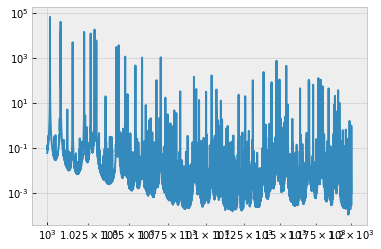

3162.2776601683795 
 0.1


In [41]:
#check for Fe I

plt.figure()
plt.plot(1.e7/nus,  op)
plt.yscale("log")
plt.xscale("log")
plt.show()
print(Tfix, '\n', Pfix)

# Compare with petitRADTRANS for METAL

written with reference to "[petitRadtran high-resolution IO.ipynb](https://gist.github.com/HajimeKawahara/69f633cfc29dffab913997a4b0e6a4c0)"

In [42]:
xrg = (11000, 11250) #(10000, 12000) 
yrg = (1e-27, 1e-17)
out_suffix = out_suffix #'_PH0.05' #'_crit120' #''

### Case of exojax

In [43]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

with open(petitdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_exo="sigma_99_3162.2776601683795.K_0.100000bar"+out_suffix+".dat"
with open(petitdir+fn_exo, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)

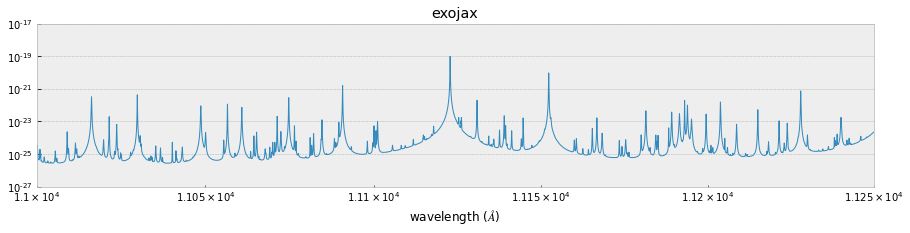

In [44]:
species_mass=55.847
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1)
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")

plt.show()
#plt.savefig(path_fig+'comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf')

### Case of petitRADTRANS

In [27]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe/"

with open (petitdir+"wlen.dat") as w:
    contentw_p = np.fromfile(w, dtype=np.float64)
    
fn_pet="sigma_99_3250.K_0.100000bar.dat"
with open(petitdir+fn_pet, 'rb') as f:
    contentf_p = np.fromfile(f, dtype=np.float64)

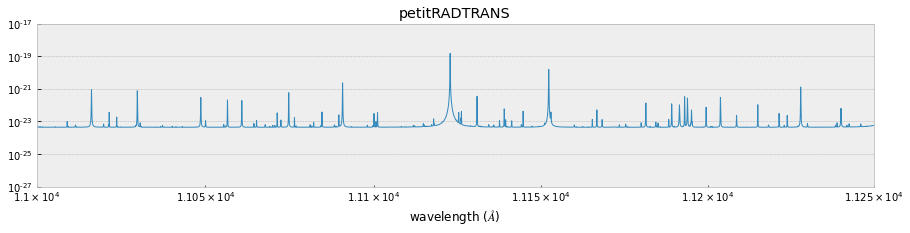

In [28]:
species_mass=55.847
xs_p=np.array(contentf_p)*species_mass*1.66053892e-24
wav_p=np.array(contentw_p,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav_p*1.e8, xs_p, lw=1)
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('petitRADTRANS')
plt.xlabel("wavelength ($\AA$)")

plt.show()
#plt.savefig(path_fig+'comp_petitR_Fe_210823.pdf')

### Difference

In [56]:
import scipy as sp
from matplotlib import gridspec

%matplotlib notebook
#%matplotlib inline

In [46]:
len( np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0] ), len( np.where((wav_p*1.e8>xrg[0]) & (wav_p*1.e8<xrg[1]))[0] )

(24238, 22472)

In [47]:
wav_p_excerpt = wav_p[np.where((wav_p*1.e8>xrg[0]-1) & (wav_p*1.e8<xrg[1]+1))[0]]
xs_p_excerpt = xs_p[np.where((wav_p*1.e8>xrg[0]-1) & (wav_p*1.e8<xrg[1]+1))[0]]
wav_excerpt = wav[np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]]
xs_excerpt = xs[np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]]
xs_p_interp = sp.interpolate.interp1d(wav_p_excerpt, xs_p_excerpt, kind="quadratic")(wav_excerpt)

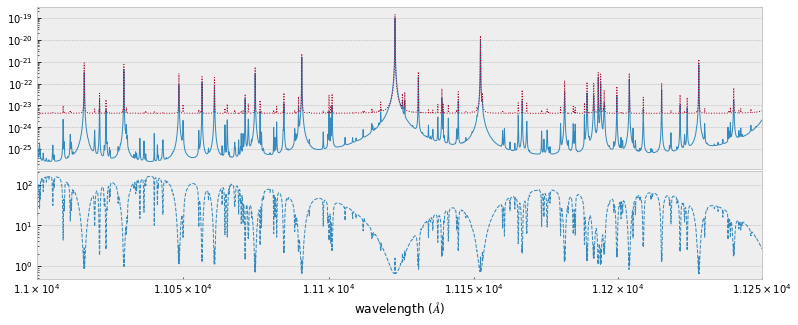

In [48]:
fig=plt.figure(figsize=(13,5)) #15, 5
gs=gridspec.GridSpec(5,1)
ax1=plt.subplot(gs[0:3])
ax2=plt.subplot(gs[3:], sharex=ax1)

ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1)
ax1.plot(wav_excerpt*1.e8, xs_p_interp, ':', lw=1)
ax2.plot(wav_excerpt*1.e8, xs_p_interp/xs_excerpt, '--', lw=1)

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.axes.xaxis.set_visible(False)
ax2.set_xlabel("wavelength ($\AA$)")

plt.subplots_adjust(hspace=.05)
plt.show()
#plt.savefig(path_fig+'comp_diff_Fe'+out_suffix+'.pdf')

### comparison with opacity calculated by Kawashima-san


In [63]:
ko_wo_VIS = np.loadtxt('Fe_0.1bar-3250K_inverted_ishikawa-frac_wo-optical-lines.dat', comments='#')

In [64]:
# Convert wavelength [Angstrom] to vacuum (from air)
def wavelength_air_to_vacuum(WL_air):
    n_pre = 1.0 + 0.0000834254 + (0.02406147 / (130.0 - (WL_air*1.000274*0.0001)**2.0)) + (0.00015998 / (38.9 - (WL_air*1.000274*0.0001)**2.0))
    n = 1.0 + 0.0000834254 + (0.02406147 / (130.0 - (WL_air*n_pre*0.0001)**2.0)) + (0.00015998 / (38.9 - (WL_air*n_pre*0.0001)**2.0))
    return(WL_air * n)
wav_yk = np.array(list(map(wavelength_air_to_vacuum, ko_wo_VIS[:, 0] * 1e4)))

In [ ]:
fig=plt.figure(figsize=(13,5)) #15, 5
plt.plot(ko_wo_VIS[:,0]*1.e4, ko_wo_VIS[:,1], lw=1)
plt.xlim(11000, 11250)
plt.yscale("log")
plt.xscale("log") 
plt.show()

<IPython.core.display.Javascript object>


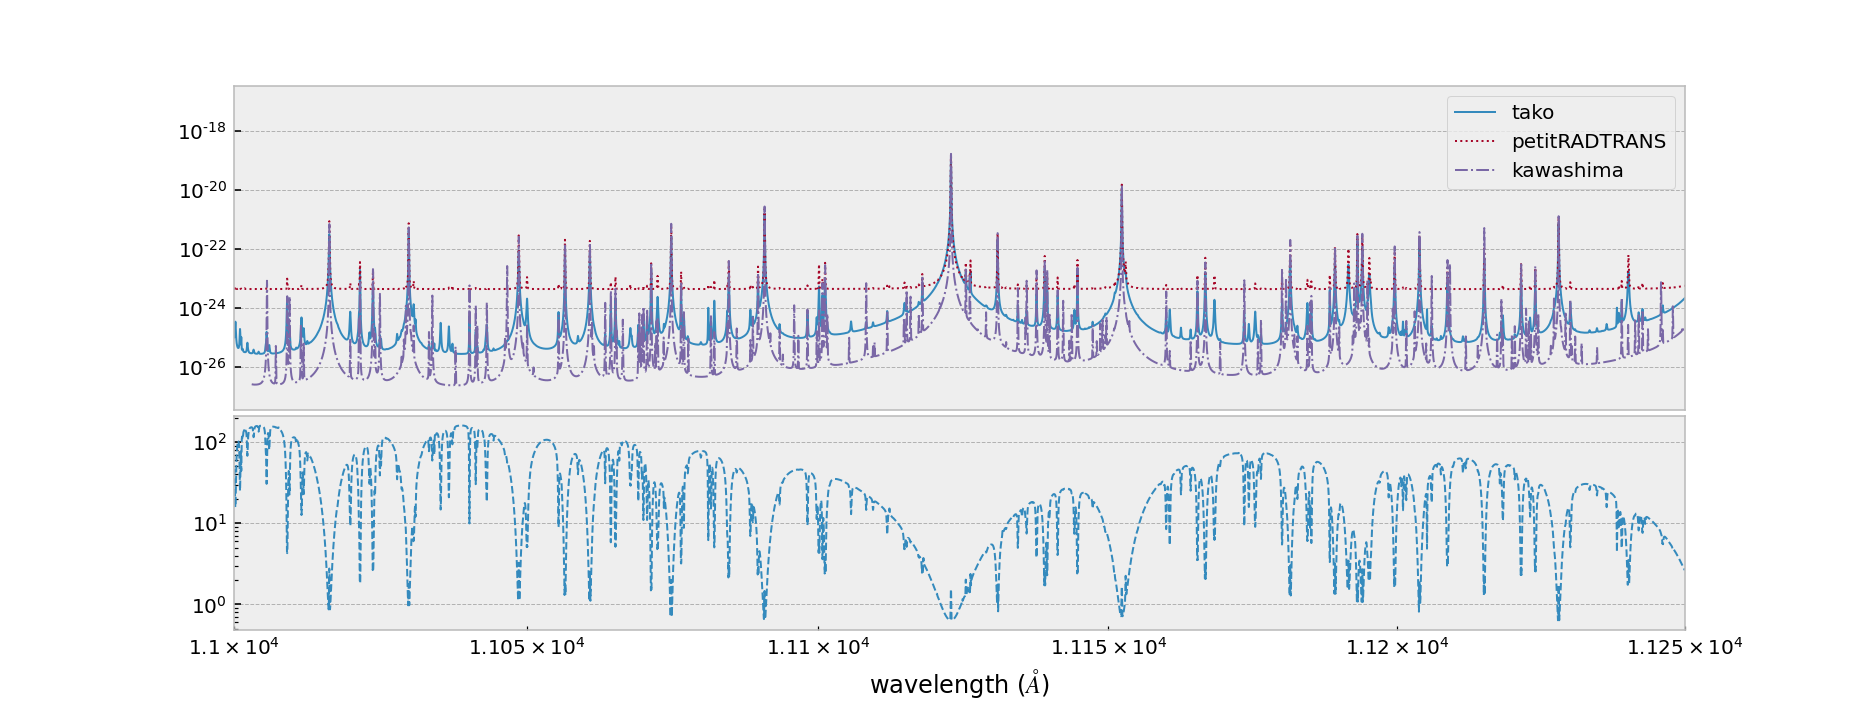

In [65]:
fig=plt.figure(figsize=(13,5)) #15, 5
gs=gridspec.GridSpec(5,1)
ax1=plt.subplot(gs[0:3])
ax2=plt.subplot(gs[3:], sharex=ax1)

ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1, label='tako')
ax1.plot(wav_excerpt*1.e8, xs_p_interp, ':', lw=1, label='petitRADTRANS')
ax1.plot(wav_yk, ko_wo_VIS[:,1], '-.', lw=1, label='kawashima')
ax2.plot(wav_excerpt*1.e8, xs_p_interp/xs_excerpt, '--', lw=1)

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.axes.xaxis.set_visible(False)
ax2.set_xlabel("wavelength ($\AA$)")
ax1.legend()

plt.subplots_adjust(hspace=.05)
plt.show()
#plt.savefig(path_fig+'comp_diff_Fe'+out_suffix+'.pdf')